In [124]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import urllib2
import re
from subprocess import PIPE, Popen
import os
import glob
import re
import math
from sklearn import feature_selection
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from scipy.stats.stats import pearsonr

In [3]:
processArray = glob.glob('/Users/triptik/Documents/classes2015/data-science/project/data/geo-preprocessed/'+'*.csv')
len(processArray)

38

In [4]:
#Creating one large dataframe from all of the normalized data
for dfInd in range(0, len(processArray)):
    df = pd.read_csv(processArray[dfInd])
    if (dfInd == 0):
        preprocAll = df
    else:
        preprocAll = preprocAll.append(df)

/Users/triptik/anaconda/lib/python2.7/site-packages/pandas/io/parsers.py:1170: DtypeWarning: Columns (21370,21371,21373) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


In [5]:
print "Dimensions of full matrix: ", preprocAll.shape
preprocAll = preprocAll[~preprocAll['age'].apply(np.isnan)]
print "Dimensions after removing NaN age: ", preprocAll.shape

Dimensions of full matrix:  (3740, 21374)
Dimensions after removing NaN age:  (2362, 21374)


In [6]:
#Using only non-cancer set for PCA and regression
preprocFull = preprocAll[preprocAll['cancer'] != 1]
#Using cancer set for prediction
cancer = preprocAll[preprocAll['cancer'] == 1]

In [7]:
preprocFull['cancer'] = preprocFull['cancer'].astype('int')
print "Number of cancer cases: ", sum(preprocFull['cancer'])

Number of cancer cases:  0


/Users/triptik/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [8]:
cancer['cancer'] = cancer['cancer'].astype('int')
print "Number of normal cases: ", sum(cancer['cancer']!=1)

Number of normal cases:  0


/Users/triptik/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [9]:
preprocFull.head()

,age,cancer,cg00000292,cg00002426,cg00003994,cg00005847,cg00007981,cg00008493,cg00008713,cg00009407,cg00011459,cg00012199,cg00012386,cg00012792,cg00013618,cg00014085,cg00014837,cg00015770,cg00019495,cg00020533,cg00021527,cg00022866,cg00024396,cg00024812,cg00025991,cg00027083,cg00027674,cg00029826,cg00031162,cg00032227,cg00033516,cg00033773,cg00034039,cg00035347,cg00035623,cg00037763,cg00037940,cg00040861,cg00040873,cg00043004,cg00043080,cg00044245,cg00047050,cg00047469,cg00050312,cg00051979,cg00054706,cg00056767,cg00057593,cg00058938,...,cg27600794,cg27601516,cg27603796,cg27606341,cg27607639,cg27609819,cg27610250,cg27610561,cg27611665,cg27611781,cg27613076,cg27614038,cg27619475,cg27622610,cg27623214,cg27625732,cg27626102,cg27626299,cg27626318,cg27626424,cg27626899,cg27627570,cg27628312,cg27631256,cg27631817,cg27633903,cg27634151,cg27635271,cg27637521,cg27638597,cg27638672,cg27638713,cg27641018,cg27643859,cg27648946,cg27649764,cg27650175,cg27650434,cg27652350,cg27653134,cg27654142,cg27655905,cg27657283,cg27662379,cg27662877,cg27665659,gender,sample_geo_id,sample_id,tissue_src
0,50,0,0.249439,0.200710,0.051357,0.742340,0.027400,0.969301,0.026876,0.076392,0.913424,0.022401,0.021674,0.040939,0.587426,0.032701,0.856025,0.154357,0.195630,0.900833,0.017518,0.655288,0.079444,0.038857,0.497367,0.031832,0.063149,0.080270,0.250808,0.023048,0.023196,0.760483,0.115967,0.402469,0.137319,0.921279,0.834481,0.019326,0.192374,0.050972,0.883098,0.117687,0.069086,0.047490,0.024613,0.089200,0.027082,0.051814,0.359395,0.372161,...,0.807422,0.114480,0.087505,0.821243,0.028356,0.819309,0.012857,0.937965,0.013561,0.049636,0.055204,0.041294,0.054690,0.638939,0.839934,0.676104,0.115339,0.193929,0.034935,0.922266,0.099631,0.019241,0.014042,0.828147,0.338333,0.096003,0.053057,0.201522,0.017144,0.018325,0.027236,0.088667,0.680592,0.774362,0.062680,0.028338,0.025860,0.148553,0.278382,0.789000,0.038908,0.104930,0.029542,0.016209,0.030511,0.060581,NaN,GSM435111,MSC-BM_donor275-50yrs_P2,Mesenchymal stromal cells from human bone marr...
1,50,0,0.308393,0.156496,0.046323,0.774976,0.031397,0.972898,0.034388,0.059107,0.898251,0.016743,0.026882,0.035031,0.538918,0.033689,0.868578,0.096916,0.322353,0.843714,0.023248,0.616212,0.062367,0.035271,0.351826,0.041107,0.075486,0.080144,0.358332,0.020370,0.037010,0.884545,0.163881,0.340100,0.230774,0.903996,0.880255,0.025161,0.175720,0.091887,0.922546,0.101318,0.046231,0.043950,0.020741,0.095850,0.028801,0.037264,0.687618,0.340435,...,0.605272,0.100390,0.073166,0.784987,0.027648,0.790344,0.016722,0.929948,0.010669,0.061113,0.060875,0.041263,0.129184,0.678039,0.822494,0.712357,0.118902,0.124903,0.032283,0.885868,0.116979,0.018599,0.018080,0.903415,0.139440,0.128764,0.050339,0.273106,0.016024,0.016994,0.046208,0.085923,0.662196,0.736597,0.176506,0.041279,0.021463,0.102437,0.175641,0.812683,0.036272,0.088281,0.044188,0.018576,0.028882,0.033358,NaN,GSM435112,MSC-BM_donor275-50yrs_P10,Mesenchymal stromal cells from human bone marr...
2,21,0,0.264882,0.115070,0.040636,0.582202,0.030823,0.970228,0.034255,0.068475,0.866214,0.016213,0.045897,0.044912,0.616433,0.091644,0.864787,0.092358,0.087612,0.897860,0.026272,0.690331,0.061439,0.034884,0.488411,0.023026,0.076324,0.098320,0.255581,0.019823,0.028036,0.807688,0.138641,0.416316,0.112507,0.905818,0.862345,0.032410,0.192246,0.023264,0.881104,0.082550,0.040390,0.035464,0.015939,0.083124,0.024062,0.035684,0.363320,0.369186,...,0.721347,0.105548,0.078780,0.704914,0.019603,0.757573,0.036962,0.912017,0.009491,0.055991,0.048848,0.036295,0.031902,0.545673,0.813566,0.690370,0.119424,0.116485,0.038911,0.910296,0.108163,0.013844,0.011653,0.779531,0.223433,0.108624,0.047437,0.107551,0.018041,0.021593,0.045750,0.062191,0.670423,0.780261,0.044256,0.053674,0.015163,0.116912,0.463504,0.784149,0.039019,0.116454,0.046746,0.015254,0.070106,0.038966,NaN,GSM435113,MSC-BM_donor277-21yrs_P2,Mesenchymal stromal cells from human bone marr...
3,25,0,0.270769,0.104574,0.043619,0.730222,0.043277,0.978465,0.034968

In [10]:
cancer.head()

,age,cancer,cg00000292,cg00002426,cg00003994,cg00005847,cg00007981,cg00008493,cg00008713,cg00009407,cg00011459,cg00012199,cg00012386,cg00012792,cg00013618,cg00014085,cg00014837,cg00015770,cg00019495,cg00020533,cg00021527,cg00022866,cg00024396,cg00024812,cg00025991,cg00027083,cg00027674,cg00029826,cg00031162,cg00032227,cg00033516,cg00033773,cg00034039,cg00035347,cg00035623,cg00037763,cg00037940,cg00040861,cg00040873,cg00043004,cg00043080,cg00044245,cg00047050,cg00047469,cg00050312,cg00051979,cg00054706,cg00056767,cg00057593,cg00058938,...,cg27600794,cg27601516,cg27603796,cg27606341,cg27607639,cg27609819,cg27610250,cg27610561,cg27611665,cg27611781,cg27613076,cg27614038,cg27619475,cg27622610,cg27623214,cg27625732,cg27626102,cg27626299,cg27626318,cg27626424,cg27626899,cg27627570,cg27628312,cg27631256,cg27631817,cg27633903,cg27634151,cg27635271,cg27637521,cg27638597,cg27638672,cg27638713,cg27641018,cg27643859,cg27648946,cg27649764,cg27650175,cg27650434,cg27652350,cg27653134,cg27654142,cg27655905,cg27657283,cg27662379,cg27662877,cg27665659,gender,sample_geo_id,sample_id,tissue_src
0,1,1,0.742377,0.489831,0.088110,0.530238,0.055664,0.972224,0.038776,0.021043,0.918520,0.021043,0.038776,0.021043,0.792886,0.021043,0.792886,0.307997,0.196877,0.850245,0.021043,0.611053,0.021043,0.038776,0.489831,0.398914,0.358506,0.134788,0.499932,0.021043,0.072061,0.884638,0.088110,0.429219,0.088110,0.898244,0.857171,0.021043,0.267590,0.103887,0.870950,0.134788,0.072061,0.038776,0.021043,0.072061,0.021043,0.055664,0.570645,0.307997,...,0.681766,0.196877,0.287793,0.489831,0.021043,0.752479,0.038776,0.742377,0.021043,0.103887,0.021043,0.021043,0.742377,0.378710,0.701970,0.641358,0.469627,0.631257,0.038776,0.931968,0.072061,0.021043,0.021043,0.419118,0.520136,0.119437,0.358506,0.752479,0.103887,0.021043,0.055664,0.103887,0.671664,0.911777,0.176673,0.021043,0.055664,0.055664,0.641358,0.611053,0.227182,0.088110,0.055664,0.021043,0.038776,0.055664,NaN,GSM519817,Breast tumor from patient P_1 (methylation data),Breast tumor
1,1,1,0.845257,0.424936,0.124736,0.718023,0.062314,0.978960,0.030818,0.015145,0.893818,0.030818,0.030818,0.030818,0.815718,0.030818,0.853433,0.210006,0.297932,0.893818,0.030818,0.796179,0.062314,0.046569,0.649636,0.708253,0.659405,0.155469,0.678944,0.030818,0.062314,0.917623,0.093666,0.317471,0.093666,0.917623,0.885809,0.030818,0.268623,0.268623,0.893818,0.093666,0.170697,0.030818,0.030818,0.046569,0.030818,0.030818,0.786409,0.493323,...,0.395627,0.170697,0.649636,0.405397,0.030818,0.796179,0.046569,0.385858,0.015145,0.180697,0.046569,0.015145,0.078020,0.288162,0.825488,0.835257,0.610558,0.639866,0.030818,0.941055,0.109241,0.046569,0.030818,0.853433,0.659405,0.190467,0.464014,0.737562,0.600788,0.030818,0.062314,0.078020,0.727792,0.901791,0.317471,0.015145,0.015145,0.278393,0.805949,0.737562,0.109241,0.078020,0.046569,0.015145,0.030818,0.046569,NaN,GSM519818,Breast tumor from patient P_10 (methylation data),Breast tumor
2,1,1,0.596649,0.203046,0.257713,0.607583,0.070087,0.985134,0.020305,0.020305,0.815318,0.020305,0.050225,0.050225,0.782518,0.020305,0.705984,0.552916,0.388914,0.826251,0.030305,0.837185,0.030305,0.030305,0.541982,0.080005,0.356114,0.246779,0.552916,0.050225,0.060161,0.847185,0.050225,0.345180,0.099824,0.920973,0.880757,0.020305,0.119627,0.080005,0.897105,0.040275,0.060161,0.030305,0.060161,0.050225,0.020305,0.089917,0.673183,0.640383,...,0.421714,0.070087,0.246779,0.541982,0.020305,0.826251,0.070087,0.421714,0.050225,0.235846,0.080005,0.020305,0.705984,0.235846,0.738784,0.847185,0.129524,0.618516,0.099824,0.847185,0.060161,0.020305,0.080005,0.716917,0.640383,0.170245,0.257713,0.454515,0.030305,0.089917,0.089917,0.070087,0.443581,0.905154,0.203046,0.010249,0.020305,0.060161,0.804385,0.695050,0.040275,0.040275,0.109727,0.020305,0.020305,0.050225,NaN,GSM519819,Breast tumor from patient P_101 (methylation d...,Breast tumor
3,1,1,0.885246,0.445778,0.192806,0.536848,0.084960,0.966961,0.021820,0.021820,0.902303,0.021820,0.034075,0.034

In [11]:
#Setting up the x and y matrices. metColumns contains the column names for the variables we want to include
#in our regression. Right now it only contains the CpG sites, because the gender is not available for all 
#datasets. You can add variables by appending the column name into metColumns
metColumns = preprocFull.columns[[re.match(r"cg", col) != None for col in preprocFull.columns]].values.tolist()


#appending cancer as one of the variables
#metColumns.append('cancer')
metDFx = preprocFull[metColumns]
cancerDFx=cancer[metColumns]

#Separating response variable
metDFy = pd.DataFrame(preprocFull['age'])
cancerDFy = pd.DataFrame(cancer['age'])

In [12]:
print metDFx.shape
print metDFy.shape

print cancerDFx.shape
print cancerDFy.shape

(1833, 21368)
(1833, 1)
(529, 21368)
(529, 1)


In [13]:
def replaceNan(column):
    columnFix = column.fillna(column.mean())
    return columnFix
metDFx = metDFx.apply(replaceNan)
cancerDFx = cancerDFx.apply(replaceNan)

In [14]:
from sklearn.cross_validation import train_test_split
itrain, itest = train_test_split(xrange(preprocFull.shape[0]), train_size=0.7)
mask=np.ones(preprocFull.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)
mask.shape, mask.sum()

((1833,), 1283)

In [15]:
Xmatrix_train=metDFx[mask]
Xmatrix_test=metDFx[~mask]
Yresp_train=metDFy[mask]['age']
Yresp_test=metDFy[~mask]['age']
Xmatrix_cancer=cancerDFx
Yresp_cancer=cancerDFy['age']

In [16]:
print Xmatrix_train.shape
print Yresp_train.shape

(1283, 21368)
(1283,)


In [17]:
%%time
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(Xmatrix_train)

CPU times: user 37.3 s, sys: 1.66 s, total: 39 s
Wall time: 22.8 s


In [18]:
#Variance explained by the principal components
#(pca.explained_variance_ratio_)

In [19]:
#Xmatrix_new = pca.transform(Xmatrix_train)

In [20]:
#sum(pca.explained_variance_ratio_)

In [21]:
#Xmatrix_new.shape

In [22]:
from sklearn import linear_model
from sklearn.linear_model import LassoCV

In [23]:
#regModel = linear_model.LinearRegression()             

In [24]:
#regModel.fit(Xmatrix_new, Yresp_train)

In [25]:
#trying a cross-validated approach

pca = PCA()
X_reduced = pca.fit_transform(Xmatrix_train)

In [26]:
sums = np.cumsum(pca.explained_variance_ratio_)*100
x = 0
k = 0
while (k<95):
    k = sums[x]
    x+=1
print "95% of variance explained in: ", x, " components"

95% of variance explained in:  63  components


In [27]:
#Defining our cross-validation: 5 folds
from sklearn import cross_validation
n = len(X_reduced)
kf_5 = cross_validation.KFold(n, n_folds=5)
regr = linear_model.LinearRegression()
mseScore = []

In [28]:
score = -1*cross_validation.cross_val_score(regr, np.ones((n,1)), Yresp_train, cv=kf_5, scoring='mean_squared_error').mean()    
mseScore.append(score) 

In [29]:
%%time
from sklearn.cross_validation import cross_val_score
ncomponents = [35, 70, 140, 280, 560, 1020, 2000]

for i in ncomponents:
    score = -1*cross_validation.cross_val_score(regr, X_reduced[:,:i], Yresp_train, cv=kf_5, scoring='mean_squared_error').mean()
    mseScore.append(score)

CPU times: user 1min 49s, sys: 1.51 s, total: 1min 50s
Wall time: 1min 45s


In [30]:
print "Highest score for:", ncomponents[mseScore.index(max(mseScore))-1], "components"

Highest score for: 1020 components


In [31]:
#Train over all of the training set
pca = PCA(n_components=1020)
Xtrain_new = pca.fit_transform(Xmatrix_train)
Xtest_new = pca.transform(Xmatrix_test)
cancer_new = pca.transform(Xmatrix_cancer)

In [32]:
regr.fit(Xtrain_new, Yresp_train)
test_predict = regr.predict(Xtest_new)
cancer_predict = regr.predict(cancer_new)

In [33]:
print "RMSE for prediction: ", np.sqrt(np.mean((test_predict - Yresp_test.values) ** 2)), "years"
print "RMSE for prediction: ", np.sqrt(np.mean((cancer_predict - Yresp_cancer.values) ** 2)), "years"

RMSE for prediction:  10.7867598613 years
RMSE for prediction:  47.5073481942 years


(-10, 80)

/Users/triptik/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


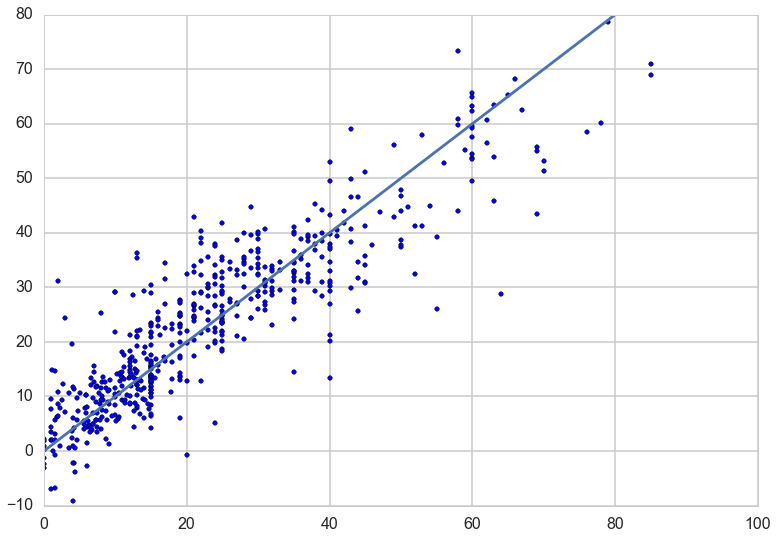

In [34]:
plt.scatter(Yresp_test.values, test_predict)
ax = plt.gca()
x = np.linspace(*ax.get_xlim())
plt.plot(x,x)
plt.xlim(0,100)
plt.ylim(-10,80)

(-10, 80)

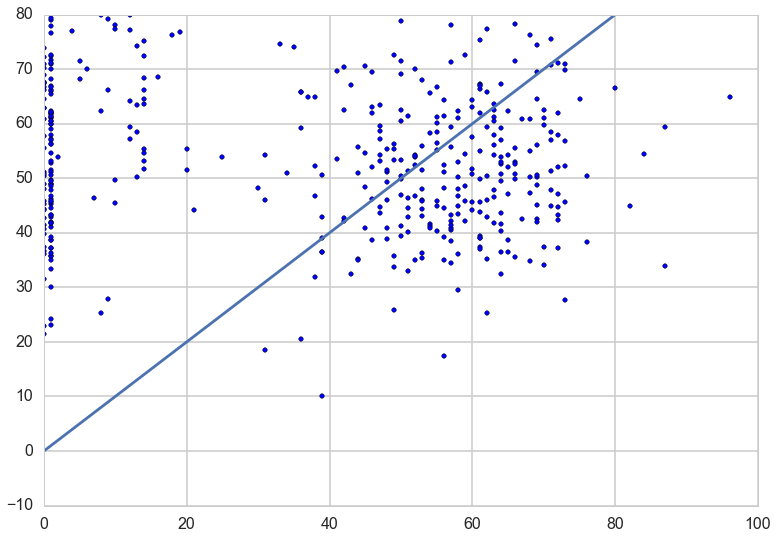

In [35]:
plt.scatter(Yresp_cancer.values, cancer_predict)
ax = plt.gca()
x = np.linspace(*ax.get_xlim())
plt.plot(x,x)
plt.xlim(0,100)
plt.ylim(-10,80)

In [36]:
wholemetDFx = preprocAll[metColumns]
wholemetDFy = pd.DataFrame(preprocAll['cancer'])
wholemetDFx = wholemetDFx.apply(replaceNan)
from sklearn.cross_validation import train_test_split
itrain, itest = train_test_split(xrange(preprocAll.shape[0]), train_size=0.7)
mask_All=np.ones(preprocAll.shape[0], dtype='int')
mask_All[itrain]=1
mask_All[itest]=0
mask_All = (mask_All==1)
mask_All.shape, mask_All.sum()
XmatrixAll_train=wholemetDFx[mask_All]
XmatrixAll_test=wholemetDFx[~mask_All]
YrespAll_train=wholemetDFy[mask_All]['cancer']
YrespAll_test=wholemetDFy[~mask_All]['cancer']
print XmatrixAll_train.shape
print YrespAll_train.shape


(1653, 21368)
(1653,)


In [90]:
from sklearn.decomposition import PCA
pca = PCA()
X_All_reduced = pca.fit_transform(XmatrixAll_train)

In [38]:
sums = np.cumsum(pca.explained_variance_ratio_)*100
x = 0
k = 0
while (k<95):
    k = sums[x]
    x+=1
print "95% of variance explained in: ", x, " components"

95% of variance explained in:  213  components


In [39]:
from sklearn.svm import LinearSVC
from sklearn import cross_validation
from sklearn.cross_validation import cross_val_score

n_All = len(X_All_reduced)
kf_All_5 = cross_validation.KFold(n_All, n_folds=5)
clfsvm=LinearSVC(loss="hinge")
ncomponents = [35, 70, 140, 280, 560, 1020, 2000]
mseScore_All = []

#Took out the scoring function - results in 70 components for linear SVM. We might want to do a GridSearch-type
#instead to 

for i in ncomponents:
    score = cross_validation.cross_val_score(clfsvm, X_All_reduced[:,:i], YrespAll_train, cv=kf_All_5).mean()
    mseScore_All.append(score)

print mseScore_All
#print "Highest score for:", ncomponents[mseScore_All.index(max(mseScore_All))-1], "components"

[0.88430101620433954, 0.86862034239677732, 0.85895266868076536, 0.8668314565595534, 0.8601519729012177, 0.8776636455186303, 0.8770594159113797]


In [40]:
pca = PCA(n_components=2000)
XtrainAll_new = pca.fit_transform(XmatrixAll_train)
XtestAll_new = pca.transform(XmatrixAll_test)

clfsvm.fit(XtrainAll_new, YrespAll_train)
testAll_predict = clfsvm.predict(XtestAll_new)

/Users/triptik/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


(0, 1)

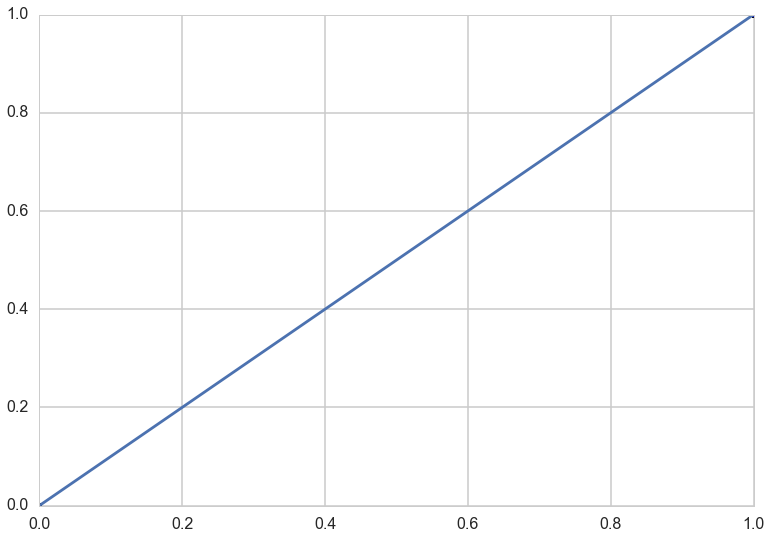

In [43]:
plt.scatter(YrespAll_test.values, testAll_predict)
ax = plt.gca()
x = np.linspace(*ax.get_xlim())
plt.plot(x,x)
plt.xlim(0,1)
plt.ylim(0,1)

In [42]:
from sklearn.metrics import confusion_matrix
confusion_matrix(YrespAll_test.values, testAll_predict)

array([[539,   0],
       [  0, 170]])

In [48]:
"""
Function
--------
cv_optimize

Inputs
------
clf : an instance of a scikit-learn classifier
parameters: a parameter grid dictionary thats passed to GridSearchCV (see above)
X: a samples-features matrix in the scikit-learn style
y: the response vectors of 1s and 0s (+ives and -ives)
n_folds: the number of cross-validation folds (default 5)
score_func: a score function we might want to pass (default python None)
   
Returns
-------
The best estimator from the GridSearchCV, after the GridSearchCV has been used to
fit the model.
     
Notes
-----
see do_classify and the code below for an example of how this is used
"""
from sklearn.metrics import accuracy_score
from sklearn.grid_search import GridSearchCV
def cv_optimize(clf, parameters, xtrain, ytrain,n_folds=5,score_func=None):
    fitmodel = GridSearchCV(clf, param_grid=parameters, cv=n_folds, scoring=score_func)
    fitmodel.fit(xtrain,ytrain)
    best=fitmodel.best_estimator_
    print best
    return best

In [121]:
def pearson_scorer(X,y):
    rs=np.zeros(X.shape[1])
    pvals=np.zeros(X.shape[1])
    i=0
    for v in X.T:
        rs[i], pvals[i]=pearsonr(v, y)
        i=i+1
    return np.abs(rs), pvals    

In [116]:
from sklearn.metrics import confusion_matrix
def do_classify(clf, parameters, indf, featurenames, targetname, target1val, mask=None, reuse_split=None, score_func=None, n_folds=5):
    subdf=(indf[featurenames]).apply(replaceNan)
    X=subdf.values
    y=(indf[targetname].values==target1val)*1
    if mask !=None:
        print "using mask"
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    if reuse_split !=None:
        print "using reuse split"
        Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'], reuse_split['Xtest'], reuse_split['ytrain'], reuse_split['ytest']
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print "############# based on standard predict ################"
    print "Accuracy on training data: %0.2f" % (training_accuracy)
    print "Accuracy on test data:     %0.2f" % (test_accuracy)
    print confusion_matrix(ytest, clf.predict(Xtest))
    print "########################################################"
    return clf, Xtrain, ytrain, Xtest, ytest

In [ ]:
#svm all features
Cs=[0.001, 0.01, 0.1, 1.0, 10.0, 100.0]


In [139]:
%%time
clfsvm, Xtrain_new, ytrain_new, Xtest, ytest = do_classify(LinearSVC(loss="hinge"), {"C":Cs}, preprocAll, metColumns, 'cancer',1,mask=mask_All)


using mask
LinearSVC(C=0.001, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0)
############# based on standard predict ################
Accuracy on training data: 1.00
Accuracy on test data:     0.99
[[539   0]
 [  5 165]]
########################################################
CPU times: user 3min 57s, sys: 13.6 s, total: 4min 10s
Wall time: 4min 14s


/Users/triptik/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


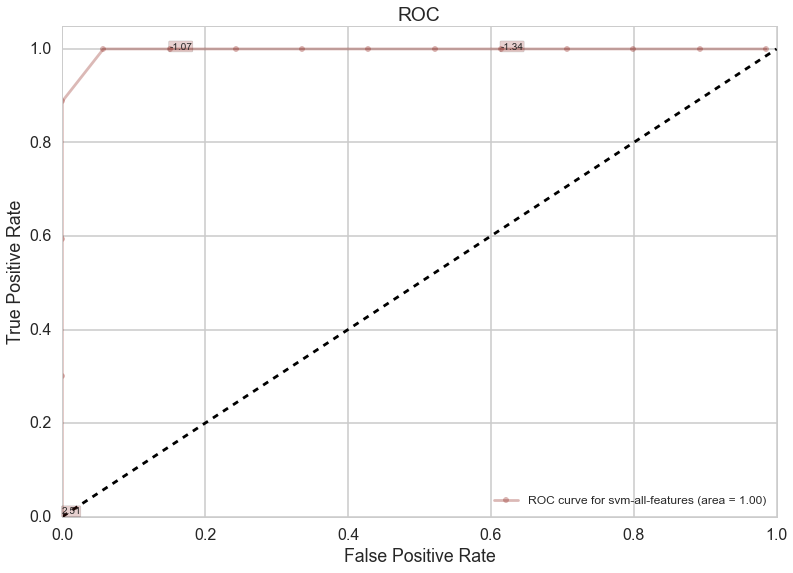

In [140]:
with sns.hls_palette(8, l=.3, s=.8):
    ax=make_roc("svm-all-features",clfsvm, ytest, Xtest, labe=250, proba=False, skip=50);

In [122]:
opt_results = []
parameters = {"svm__C": Cs}
selectorlinearsvm = SelectKBest(k=25,score_func=pearson_scorer)
pipelinearsvm = Pipeline([('select', selectorlinearsvm), ('svm', LinearSVC(loss="hinge"))])

In [128]:
lcols = wholemetDFx.columns
pipelinearsvm,Xtrain, ytrain, Xtest, ytest  = do_classify(pipelinearsvm, parameters, preprocAll, metColumns, 'cancer',1,mask=mask_All)

using mask
Pipeline(steps=[('select', SelectKBest(k=25, score_func=<function pearson_scorer at 0x10e88cb18>)), ('svm', LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0))])
############# based on standard predict ################
Accuracy on training data: 0.98
Accuracy on test data:     0.99
[[537   2]
 [  7 163]]
########################################################


/Users/triptik/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [137]:
feature_selected_cols = np.array(metColumns)[pipelinearsvm.get_params()['select'].get_support()]
feature_selected_cols

array(['cg00332153', 'cg03473518', 'cg04289385', 'cg04754011',
       'cg07717632', 'cg09573795', 'cg10660256', 'cg12556134',
       'cg13282837', 'cg14417329', 'cg15824056', 'cg16463460',
       'cg19096475', 'cg19308222', 'cg19797376', 'cg19814116',
       'cg20588069', 'cg21233722', 'cg21296676', 'cg21601405',
       'cg21794225', 'cg22377389', 'cg23282559', 'cg24840099', 'cg27169020'], 
      dtype='|S10')

In [130]:
from sklearn.metrics import roc_curve, auc
def make_roc(name, clf, ytest, xtest, ax=None, labe=5, proba=True, skip=0,fc=None):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:#for stuff like logistic regression
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:#for stuff like SVM
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    roc_auc = auc(fpr, tpr)
    if skip:
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.1', alpha=0.2 , fc=fc
    )
    
    if labe!=None:
        for k in xrange(0, fpr.shape[0],labe):
            #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
            threshold = str(np.round(thresholds[k], 2))
            ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
    ax.legend(loc="lower right",fontsize=12)
    return ax

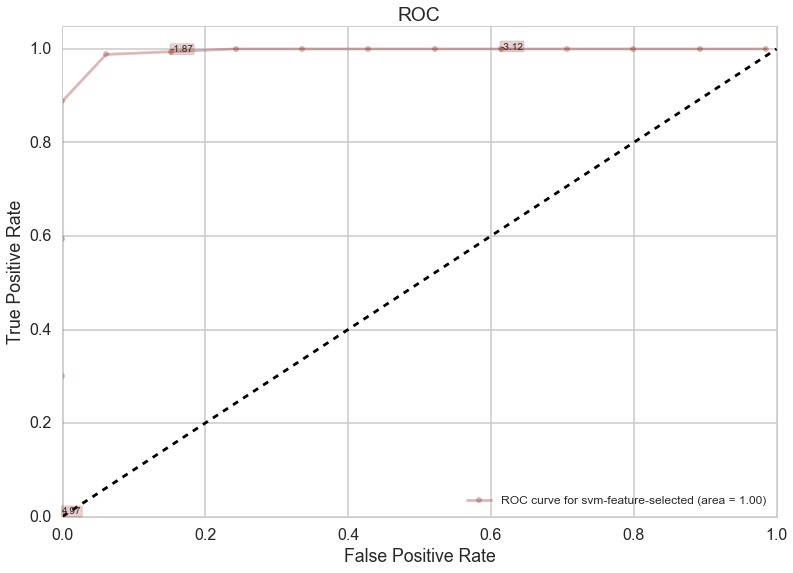

In [133]:
with sns.hls_palette(8, l=.3, s=.8):
    ax=make_roc("svm-feature-selected",pipelinearsvm, ytest, Xtest, labe=250, proba=False, skip=50);